In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import preprocessing as pp
from nltk.stem.snowball import SnowballStemmer
import lightgbm as lgb

load and preprocess data

In [2]:
def prepare_data(threshold, featureCols = None):
    data = pd.read_csv("train.csv")
    data = data.reindex(np.random.permutation(data.index))
    train = data[:38000].copy()
    #train[['Year','Month','Hour']] = train.apply(pp.accidentTime, axis=1,result_type='expand')
    keywords = pp.getKeywords(train, threshold = threshold)
    pp.removeInvalid(data)
    pp.removeInconsistent(data, 18)
    pp.impute(data, train.dropna())
    #data = pp.addFeatures(data, train, keywords = keywords)
    processedData = pp.addFeatures(data, train.dropna().copy(), keywords = keywords)
    #print(data.shape, processedData.shape)
    train = processedData[:38000]
    valid1 = processedData[38000:42000]
    valid2 = processedData[42000:46000]
    test = processedData[46000:]
    if featureCols is None:
        featureCols = []
        for col in processedData.columns:
            if type(processedData.loc[0,col]) != str and 'UltimateIncurredClaimCost' not in col:
                featureCols.append(col)
    Xtrain = train[featureCols].values
    ytrain = train['UltimateIncurredClaimCost'].values
    Xvalid1 = valid1[featureCols].values
    yvalid1 = valid1['UltimateIncurredClaimCost'].values
    Xvalid2 = valid2[featureCols].values
    yvalid2 = valid2['UltimateIncurredClaimCost'].values
    Xtest = test[featureCols].values
    ytest = test['UltimateIncurredClaimCost'].values
    return Xtrain, ytrain, Xvalid1, yvalid1, Xvalid2, yvalid2, Xtest, ytest, keywords, featureCols

Custom metric for evaluation

In [3]:
def exp_rmse(y_true, y_pred):
    loss = np.mean((np.exp(y_true)-np.exp(y_pred))**2)**0.5
    return "rmse", loss, False

Model Training

In [4]:
np.random.seed(42)
Xtrain, ytrain, Xvalid1, yvalid1, Xvalid2, yvalid2, Xtest, ytest, keywords, features = prepare_data(3e-4)
Xtv2 = np.vstack((Xtrain, Xvalid2))
ytv2 = np.hstack((ytrain, yvalid2))
breg = lgb.LGBMRegressor(num_leaves = 15, learning_rate = 0.03, n_estimators = 1000, min_child_samples = 30)
#breg.fit(Xtv2, ytv2, eval_set = (Xvalid1, yvalid1))
breg.fit(Xtv2, np.log(ytv2), eval_set = (Xvalid1, np.log(yvalid1)), eval_metric = exp_rmse)
best_iter = np.argmin(breg.evals_result_['valid_0']['rmse'])
ytesthat = np.exp(breg.predict(Xtest, num_iteration = best_iter))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3355
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 269
[LightGBM] [Info] Start training from score 8.059611


Model Accuracy

In [5]:
best_iter = np.argmin(breg.evals_result_['valid_0']['rmse'])
ytesthat = np.exp(breg.predict(Xtest, num_iteration = best_iter))

In [6]:
np.mean((ytest-ytesthat)**2)**0.5

22090.239590808127

Effect of features

In [7]:
X = np.vstack((Xtrain, Xvalid1, Xvalid2, Xtest))
y = np.hstack((ytrain, yvalid1, yvalid2, ytest))
yhat = np.exp(breg.predict(X, num_iteration = best_iter))
#yhat = breg.predict(X, num_iteration = best_iter)
yhatmean = yhat.mean()

Effect of gender

In [8]:
Xperturbed = X.copy()
Xperturbed[:,15] = 1
Xperturbed[:,16] = 0
yMale = np.exp(breg.predict(Xperturbed, num_iteration = best_iter))
#yMale = breg.predict(Xperturbed, num_iteration = best_iter)

In [9]:
yMaleAvg = yMale.mean()

In [10]:
Xperturbed = X.copy()
Xperturbed[:,15] = 0
Xperturbed[:,16] = 1
yFemale = np.exp(breg.predict(Xperturbed, num_iteration = best_iter))
#yFemale = breg.predict(Xperturbed, num_iteration = best_iter)

In [11]:
yFemaleAvg = yFemale.mean()

Data suggests female gender is associated with 1.4% higher ultimate loss, on average.

In [12]:
yFemaleAvg/yMaleAvg

1.0138050587499816

In [13]:
yFemaleAvg/yhatmean

1.0101819140200077

In [14]:
yMaleAvg/yhatmean

0.9964261919007966

Effect of age

In [15]:
def partial_dependency(model, X, perturb_index, perturb_values, best_iter):
    X_perturb = X.copy()
    result = []
    for value in perturb_values:
        X_perturb[:,perturb_index] = value
        y_perturb = np.exp(model.predict(X_perturb, num_iteration = best_iter))
        #y_perturb = model.predict(X_perturb, num_iteration = best_iter)
        result.append(y_perturb.mean())
    return result

In [16]:
ages = [20,25,30,35,40,45,50,55,60,65]
mean_ages = partial_dependency(breg, X, 0, ages, best_iter)
effect_ages = [100*(x/yhatmean-1) for x in mean_ages]
plt.style.use('ggplot')

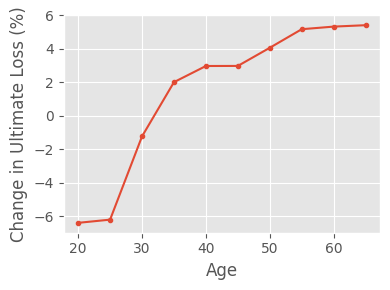

In [17]:
plt.figure(figsize=(4,3))
plt.plot(ages, effect_ages,'.-')
plt.xlabel("Age")
plt.ylabel("Change in Ultimate Loss (%)")
plt.tight_layout()
plt.savefig("age_effect.pdf")

Effect of the number of children

In [18]:
nchild = [0,1,2,3]
mean_nchild = partial_dependency(breg, X, 1, nchild, best_iter)
effect_nchild = [100*(x/yhatmean-1) for x in mean_nchild]

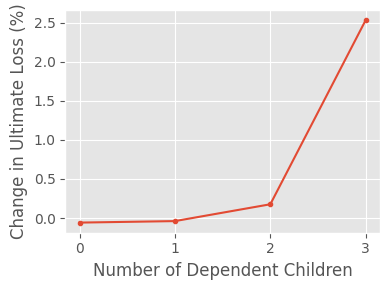

In [19]:
plt.figure(figsize=(4,3))
plt.plot(nchild, effect_nchild,'.-')
plt.xticks([0,1,2,3])
plt.xlabel("Number of Dependent Children")
plt.ylabel("Change in Ultimate Loss (%)")
plt.tight_layout()
plt.savefig("children_effect.pdf")
#plt.title("Effect of #Children on Ultimate Loss")

Having more than 2 dependent children is associated with 2.6% increase in ultimate loss

In [20]:
mean_nchild[3]/mean_nchild[0]

1.025948206455025

In [21]:
effect_nchild

[-0.05882973761877075,
 -0.03958708786286902,
 0.17600626781275608,
 2.534464381706303]

In [22]:
features[:5]

['Age',
 'DependentChildren',
 'DependentsOther',
 'WeeklyWages',
 'HoursWorkedPerWeek']

Effect of other dependents, excluding children

In [23]:
ndep = [0,1,2]
mean_ndep = partial_dependency(breg, X, 2, ndep, best_iter)
effect_ndep = [100*(x/yhatmean-1) for x in mean_ndep]

Text(0, 0.5, 'Change in Ultimate Loss (%)')

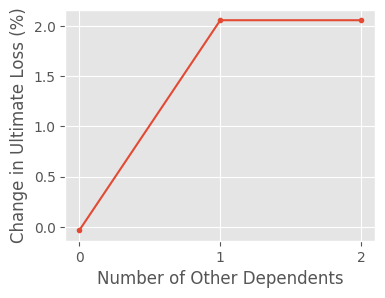

In [24]:
plt.figure(figsize=(4,3))
plt.plot(ndep, effect_ndep,'.-')
plt.xticks([0,1,2])
plt.xlabel("Number of Other Dependents")
plt.ylabel("Change in Ultimate Loss (%)")

Having other dependents is associated with a 2.1% increase in ultimate loss

In [25]:
mean_ndep[1]/mean_ndep[0]

1.0209032199349624

In [26]:
def top_words(X, Xref, features, top_k = 10):
    Xmean = X.mean(axis=0)+1e-5
    Xrefmean = Xref.mean(axis=0)+1e-5
    c = {}
    for i in range(len(features)):
        if 'KW' in features[i]:
            c[features[i][3:]] = Xmean[i]/Xrefmean[i]
    return {k: v for k, v in sorted(c.items(), key=lambda item: item[1], reverse=True)[:top_k]}

In [27]:
index = np.where(X[:,2] == 1)[0]
print(len(index))
print(np.mean(X[index,4]),np.mean(X[index,3]),np.mean(X[index,0]))
print(top_words(X[index], X, features))

462
38.082554112554114 576.500670995671 38.90692640692641
{'GUN': 4.047015251249373, 'HERNIA': 3.501989924629174, 'GROIN': 3.2383593990069706, 'DRUMS': 3.2164760673443005, 'INGUINAL': 2.8198920077834484, 'STRESS': 2.8073442378431093, 'ACCIDENT': 2.684897130172453, 'DROPPED': 2.550247725468386, 'UNLOADING': 2.4958540446436364, 'VEHICLE': 2.46649331469206}


Effect of initial reported loss

I choose to quantify its effect using a multiplying factor, as I think this is the easiest to understand.
Consider the alternative. Setting (or increasing) the initial reported loss at certain fixed value may not
be consistent across different years, due to inflation. We could do that in real terms, after adjusting for
inflation. But then we would have to explain on that, which would be distracting.

In [28]:
#multiples = np.array([0.5,0.75,1,1.25,1.5,1.75,2])
multiples = np.arange(0.5,2.1,0.1)
mean_initial = []
for value in multiples:
    X_perturb = X.copy()
    X_perturb[:,[6,-1]] *= value
    #X_perturb[:,-2] *= value
    y_perturb = np.exp(breg.predict(X_perturb, num_iteration = best_iter))
    #y_perturb = breg.predict(X_perturb, num_iteration = best_iter)
    mean_initial.append(y_perturb.mean())

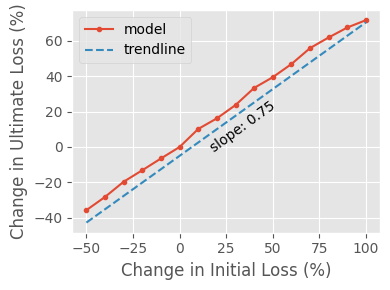

In [29]:
plt.figure(figsize=(4,3))
effect_initial = [100*(x/yhatmean-1) for x in mean_initial]
beta = np.dot(100*(multiples-1),effect_initial)/np.dot(100*(multiples-1),100*(multiples-1))
plt.plot(100*(multiples-1),effect_initial,'.-')
plt.plot(100*(multiples-1),100*beta*(multiples-1)-5,'--')
plt.text(15,-3,"slope: 0.75", rotation=36)
plt.xlabel("Change in Initial Loss (%)")
plt.ylabel("Change in Ultimate Loss (%)")
plt.legend(['model','trendline'])
plt.tight_layout()
plt.savefig("initial_estimate_effect.pdf")
#plt.xscale("log")
#plt.yscale("log")

In [30]:
beta

0.7539901993215498

Each percent of increase in initial loss is associated with 0.73 percent of
increase in ultimate loss.

Effect of wage, given fixed working hours and days.

Again, to prevent distraction from the technical details of inflation adjustment,
I use multiplying factors to quantify the effect

In [31]:
multiples = np.arange(0.5,2.1,0.1)

mean_vs_wages = []
for value in multiples:
    X_perturb = X.copy()
    X_perturb[:,[3,11,12,-4,-3,-2]] *= value
    #X_perturb[:,-2] *= value
    #y_perturb = breg.predict(X_perturb, num_iteration = best_iter)
    y_perturb = np.exp(breg.predict(X_perturb, num_iteration = best_iter))
    mean_vs_wages.append(y_perturb.mean())

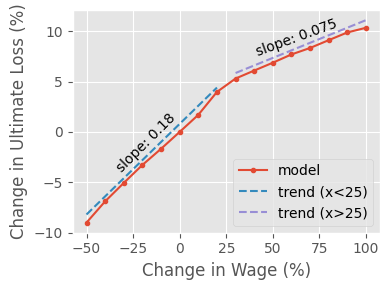

In [32]:
plt.figure(figsize=(4,3))
effect_wage = [100*(x/yhatmean-1) for x in mean_vs_wages]
#beta = np.dot(100*(multiples-1),effect_initial)/np.dot(100*(multiples-1),100*(multiples-1))
plt.plot(100*(multiples-1),effect_wage,'.-')
plt.plot(100*(multiples[:8]-1),18*(multiples[:8]-1)+0.8,'--')
plt.plot(100*(multiples[8:]-1),7.5*(multiples[8:]-1)+3.6,'--')
plt.text(-35,-4,"slope: 0.18",rotation=45)
plt.text(40,7.5,"slope: 0.075",rotation=20)
plt.xlabel("Change in Wage (%)")
plt.ylabel("Change in Ultimate Loss (%)")
plt.legend(['model','trend (x<25)',"trend (x>25)"],loc='lower right')
plt.tight_layout()
plt.savefig("wage_effect.pdf")

1% increase in wage is usually associated with 0.18% increase in ultimate loss. However, the effect
quickly winds down beyond 25%, with each percent increase is associated with 0.075% increase in 
ultimate loss.

The effect of number of days it has taken to report the incident.

In [33]:
day2report = np.arange(0,101,10)
#day2report = np.array([1,3,9,27,81,243])
mean_vs_d2r = partial_dependency(breg, Xtrain, 7, day2report, best_iter)
effect_d2r = [100*(x/yhatmean-1) for x in mean_vs_d2r]

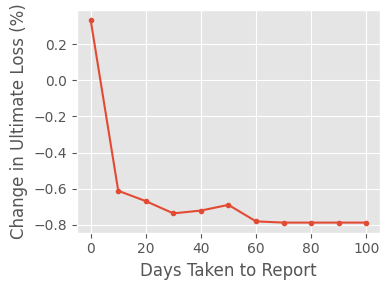

In [34]:
plt.figure(figsize=(4,3))
plt.plot(day2report, effect_d2r,'.-')
plt.xlabel("Days Taken to Report")
plt.ylabel("Change in Ultimate Loss (%)")
#plt.title("Effect of Days-to-Report on Ultimate Loss")
plt.tight_layout()
plt.savefig("d2r_effect.pdf")

In [35]:
effect_d2r

[0.33210612408567375,
 -0.6111222025532492,
 -0.6684279017168726,
 -0.7360832633292014,
 -0.7205699804389343,
 -0.6890755132335169,
 -0.780326852301727,
 -0.7870978469770362,
 -0.7870978469770362,
 -0.7870978469770362,
 -0.7870978469770362]

If an incident is reported immediately, the ultimate loss is expected to be 0.33% higher
than average. However, the trend drops quickly.

Effect of number of hours working per day, assuming hourly wage (and working days) fixed.

In [36]:
#hours per day
#assuming hourly wage constant
hours = np.array([x for x in range(4,15)])#[4,6,8,10,12,14]

mean_vs_hours = []
for value in hours:
    X_perturb = X.copy()
    #hours per week = hours per day * day per week
    X_perturb[:,4] = value*X_perturb[:,5]
    X_perturb[:,3] = X_perturb[:,4] * X_perturb[:,11]
    X_perturb[:,-2] = X_perturb[:,4] * X_perturb[:,-4]
    X_perturb[:,12] = X_perturb[:,3] / X_perturb[:,5]
    X_perturb[:,-3] = X_perturb[:,-2] / X_perturb[:,5]
    y_perturb = np.exp(breg.predict(X_perturb, num_iteration = best_iter))
    mean_vs_hours.append(y_perturb.mean())

In [37]:
effect_hours = [100*(x/yhatmean-1) for x in mean_vs_hours]

In [38]:
hdm = hours - hours.mean()
beta = np.dot(hdm,effect_hours)/np.dot(hdm,hdm)

In [39]:
beta

1.7931639036260538

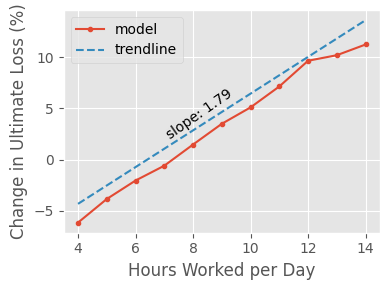

In [40]:
plt.figure(figsize=(4,3))
plt.plot(hours, effect_hours,'.-')
plt.plot(hours, beta*hours-11.5,'--')
plt.text(7,2,"slope: 1.79",rotation=35)
plt.xlabel("Hours Worked per Day")
plt.ylabel("Change in Ultimate Loss (%)")
plt.legend(['model','trendline'])
plt.tight_layout()
plt.savefig("hours_worked_effect.pdf")

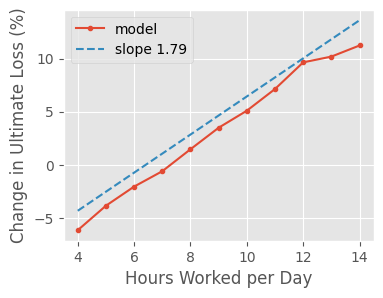

In [41]:
plt.figure(figsize=(4,3))
plt.plot(hours, effect_hours,'.-')
plt.plot(hours, beta*hours-11.5,'--')
plt.xlabel("Hours Worked per Day")
plt.ylabel("Change in Ultimate Loss (%)")
plt.legend(['model','slope 1.79'])

In [42]:
beta

1.7931639036260538

Each additional hour worked per day is associated with 1.79% increase in ultimate loss.

Effect of number of days worked per week

In [43]:
days = np.array([1,2,3,4,5,6,7])

mean_vs_days = []
for value in days:
    X_perturb = X.copy()
    X_perturb[:,5] = value
    X_perturb[:,3] = X_perturb[:,5] * X_perturb[:,12]
    X_perturb[:,4] = X_perturb[:,3] / X_perturb[:,11]
    X_perturb[:,-1] = X_perturb[:,5] * X_perturb[:,-2]
    y_perturb = np.exp(breg.predict(X_perturb, num_iteration = best_iter))
    mean_vs_days.append(y_perturb.mean())

In [44]:
effect_days = [100*(x/yhatmean-1) for x in mean_vs_days]

In [45]:
ddm = days - days.mean()
beta = np.dot(ddm,effect_days)/np.dot(ddm,ddm)

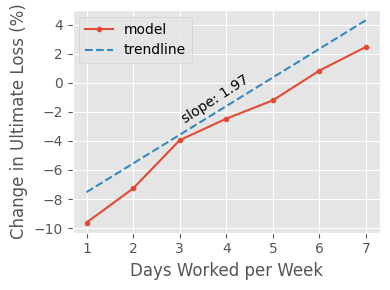

In [46]:
plt.figure(figsize=(4,3))
plt.plot(days, effect_days,'.-')
plt.plot(days, beta*days-9.5,'--')
plt.xlabel("Days Worked per Week")
plt.ylabel("Change in Ultimate Loss (%)")
plt.text(3,-2.8,"slope: 1.97",rotation=33)
#plt.title("Effect of Working Days on Ultimate Loss")
plt.legend(['model','trendline'])
plt.tight_layout()
plt.savefig("days_worked_effect.pdf")

Each additional day worked per week is associated with 1.97% increase in ultimate loss

Effect due to when (which month) did the accident happen

In [47]:
a_months = [x for x in range(1,13)]
mean_vs_a_months = partial_dependency(breg, X, 9, a_months, best_iter)
effect_a_months = [100*(x/yhatmean-1) for x in mean_vs_a_months]

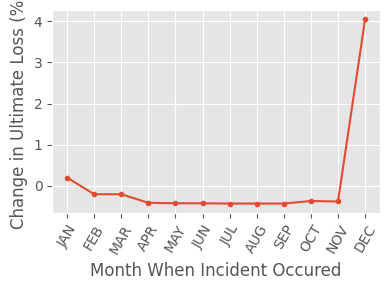

In [48]:
plt.figure(figsize=(4,3))
plt.plot(a_months, effect_a_months,'.-')
plt.xlabel("Month When Incident Occured")
plt.ylabel("Change in Ultimate Loss (%)")
#plt.title("Effect of Incident Month on Ultimate Loss")
plt.xticks(a_months,['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'],rotation=60)
plt.tight_layout()
plt.savefig("month_effect.pdf")

([<matplotlib.axis.XTick at 0x7efd7eb56fb0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12')])

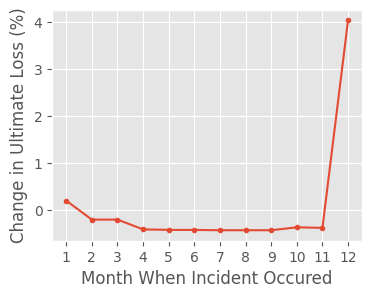

In [49]:
plt.figure(figsize=(4,3))
plt.plot(a_months, effect_a_months,'.-')
plt.xlabel("Month When Incident Occured")
plt.ylabel("Change in Ultimate Loss (%)")
#plt.title("Effect of Incident Month on Ultimate Loss")
plt.xticks(a_months,a_months)

We can see the ultimate loss tend to be higher during Dec, Jan, Feb and Mar, which are summer and early autumn in Australia

Effect of hour when accident happened

In [50]:
accident_hours = [x for x in range(0,24,2)]
mean_vs_a_hours = partial_dependency(breg, X, 10, accident_hours, best_iter)
effect_a_hours = [100*(x/yhatmean-1) for x in mean_vs_a_hours]

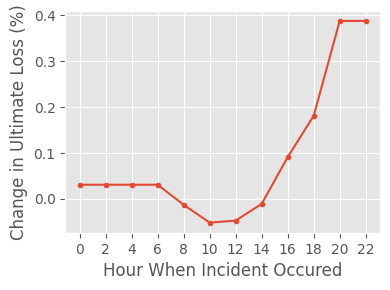

In [51]:
plt.figure(figsize=(4,3))
plt.plot(accident_hours, effect_a_hours,'.-')
plt.xlabel("Hour When Incident Occured")
plt.ylabel("Change in Ultimate Loss (%)")
plt.xticks(accident_hours,accident_hours)
plt.tight_layout()
plt.savefig("hour_effect.pdf")

We can see the loss tend to be higher out of usual working hours

Effect of employment status, i.e. Full Time or Part Time

In [52]:
fulltime = [0,1]
mean_ft = partial_dependency(breg, Xtrain, 20, fulltime, best_iter)

In [53]:
mean_ft[0]/yhatmean

1.0174402474874527

In [54]:
mean_ft[1]/yhatmean

0.9913350883537964

In [55]:
mean_ft[0]/mean_ft[1]

1.026333335156134

Part time employment is associated with 2.6% higher loss

Effect of marital status

In [56]:
indices = [17,18,19]
X_perturb = Xtrain.copy()
result = []
for index in indices:
    X_perturb[:,indices] =0
    X_perturb[:,index] = 1
    y_perturb = np.exp(breg.predict(X_perturb, num_iteration = best_iter))
    result.append(y_perturb.mean())

In [57]:
result

[8043.933390272137, 7946.080793206723, 8115.396810466927]

In [58]:
features[18]

'MaritalIsS'

In [59]:
features[19]

'MaritalIsU'

In [60]:
X[:,19].sum()/X.shape[0]

0.09803703703703703

In [61]:
[100*(x/yhatmean-1) for x in result]

[-0.21293626830388712, -1.4268229162822221, 0.6735858496050406]

Being married is associated with 0.21% decrease in loss, being single a 1.43% decrease, and unknown a 0.67% increase.

In [62]:
indices = range(21,len(features)-4)

result = []
for index in indices:
    X_perturb = Xtrain.copy()
    X_perturb[:,index] += 1
    X_perturb[:,14] += 1
    y_perturb = np.exp(breg.predict(X_perturb, num_iteration = best_iter))
    result.append(y_perturb.mean())

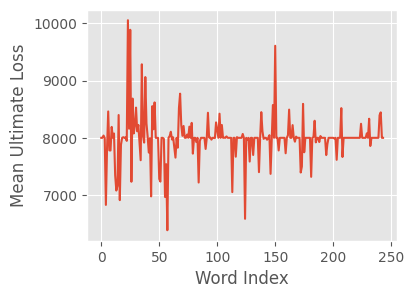

In [63]:
plt.figure(figsize=(4,3))
plt.xlabel("Word Index")
plt.ylabel("Mean Ultimate Loss")
plt.plot(result)

In [64]:
top_neg = [(features[21+x][3:],round((result[x]/yhatmean-1)*100,2)) for x in np.argsort(np.array(result))[:10]]

In [65]:
kws_neg = [x[0] for x in top_neg]
gain_neg = [x[1] for x in top_neg]

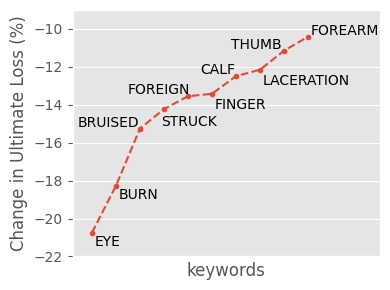

In [66]:
plt.figure(figsize=(4,3))
plt.plot(np.arange(10),gain_neg,'.--')
offsets = np.zeros((10,2)) + np.array([0.1,-0.7])
offsets[2,0] = -2.6
offsets[2,1] = .1
offsets[3,0] = -0.1
offsets[3,1] = -0.9
offsets[4,0] = -2.5
offsets[4,1] = 0.1
offsets[5,0] = 0.1
offsets[5,1] = -0.8
offsets[6,0] = -1.5
offsets[6,1] = 0.1
offsets[7,0] = 0.1
offsets[7,1] = -0.8
offsets[8,0] = -2.2
offsets[8,1] = 0.1
offsets[9,1] = 0.1
for i in range(10):
    plt.text(i+offsets[i,0],gain_neg[i]+offsets[i,1],kws_neg[i])
plt.xlim(-0.8,12)
plt.ylim(-22,-9)
plt.xticks([])
plt.xlabel("keywords")
plt.ylabel("Change in Ultimate Loss (%)")
plt.tight_layout()
plt.savefig("neg_word_effect.pdf")

In [67]:
top_pos = [(features[21+x][3:],round((result[x]/yhatmean-1)*100,2)) for x in np.argsort(-np.array(result))[:10]]
kws_pos = [x[0] for x in top_pos]
gain_pos = [x[1] for x in top_pos]

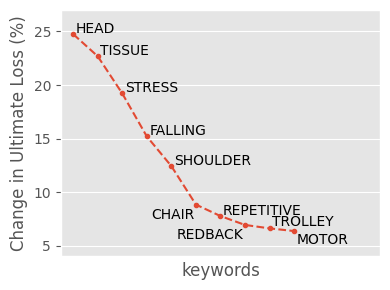

In [68]:
plt.figure(figsize=(4,3))
plt.plot(np.arange(10),gain_pos,'.--')
offsets = np.zeros((10,2)) + np.array([0.1,0.1])
#offsets[2,0] = -2.3
#offsets[2,1] = -1.2
offsets[5,0] = -1.8
offsets[5,1] = -1.3
offsets[7,0] = -2.8
offsets[7,1] = -1.3
offsets[8,0] = 0.1
offsets[8,1] = 0.2
offsets[9,1] = -1.2
for i in range(10):
    plt.text(i+offsets[i,0],gain_pos[i]+offsets[i,1],kws_pos[i])
plt.xlim(-0.5,12.5)
plt.ylim(4,27)
plt.xticks([])
plt.xlabel("keywords")
plt.ylabel("Change in Ultimate Loss (%)")
plt.tight_layout()
plt.savefig("pos_word_effect.pdf")

In [69]:
breg

LGBMRegressor(learning_rate=0.03, min_child_samples=30, n_estimators=1000,
              num_leaves=15)

In [70]:
gain = breg.booster_.feature_importance('gain')

In [71]:
index = np.argsort(-gain)

In [72]:
for i in index[:20]:
    print(features[i], int(np.round(gain[i])))

InitialIncurredClaimCost 1249539
KW:LACERATION 24150
KW:EYE 19301
KW:STRAIN 17297
KW:BACK 13495
KW:SHOULDER 11432
HourlyWage 10631
DailyWage 8106
Year 7770
KW:FOREIGN 6753
KW:TISSUE 6663
KW:FINGER 6025
WeeklyWages 5991
KW:STRUCK 5738
KW:BRUISED 4542
KW:HAND 4370
Age 4300
RealInitialIncurredClaimCost 3509
KW:KNEE 3477
KW:FRACTURE 3439


Text(0.5, 0, 'Importance')

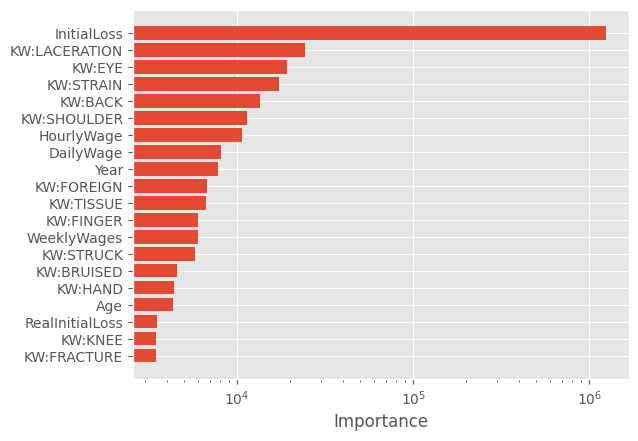

In [73]:
plt.barh(19-np.arange(20),gain[index[:20]])
plt.xscale('log')
feature_strs = [features[i] for i in index[:20]]
feature_strs[0] = 'InitialLoss'
feature_strs[17] = 'RealInitialLoss'
plt.yticks(19-np.arange(20),feature_strs)
plt.xlabel("Importance")

In [74]:
gain.sum()

1457530.5575284362

In [75]:
gain[6]/gain.sum()

0.8572986773704567

In [76]:
sum(gain[i] for i in range(len(features)) if 'KW' in features[i])/gain.sum()

0.10796487230045664

In [77]:
features[8]

'Year'

In [78]:
[(features[i],gain[i]/gain.sum()) for i in range(len(features)) if 'KW' not in features[i]]

[('Age', 0.002950107984697725),
 ('DependentChildren', 8.906542133539587e-05),
 ('DependentsOther', 1.569917948322276e-05),
 ('WeeklyWages', 0.004110719189657961),
 ('HoursWorkedPerWeek', 0.0005327922558603862),
 ('DaysWorkedPerWeek', 2.716861734087716e-05),
 ('InitialIncurredClaimCost', 0.8572986773704567),
 ('DayToReport', 0.0010031992631988264),
 ('Year', 0.0053309284847978585),
 ('Month', 0.000610533059189735),
 ('Hour', 0.0005597720282986279),
 ('HourlyWage', 0.007293796028515493),
 ('DailyWage', 0.005561624858856422),
 ('DescLenChar', 0.0011055933356155336),
 ('DescLenWord', 0.0002460256226877111),
 ('GenderIsM', 0.00010154794805812895),
 ('GenderIsF', 6.653251184853578e-05),
 ('MaritalIsM', 7.032975160966436e-05),
 ('MaritalIsS', 0.0001499442958103703),
 ('MaritalIsU', 7.98131058676027e-05),
 ('FullTime', 6.472735765700252e-05),
 ('RealHourlyWage', 0.0004907843940842636),
 ('RealDailyWage', 0.0008398488899224186),
 ('RealWeeklyWages', 0.0010283212589063519),
 ('RealInitialIncurr